<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/model-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

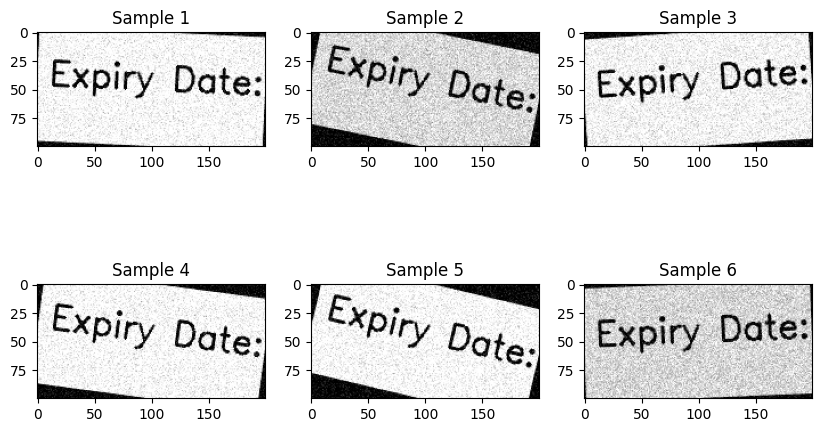

Sample 1 - EasyOCR: [([[3, 14], [197, 14], [197, 67], [3, 67]], 'Expiry Date:', 0.9995535072932067)]
Sample 1 - Tesseract: } ee
Expiry Date:

Sample 2 - EasyOCR: [([[13.216162278996459, -1.938177642322314], [116.93071851260436, 24.170533334328237], [103.78383772100354, 70.93817764232232], [0.06928148739563866, 43.82946666567176]], 'Expiry', 0.9697811867804759), ([[121.21553545944727, 24.07767729723632], [208.95246587581954, 45.38517197487252], [198.78446454055273, 81.92232270276368], [111.04753412418047, 60.61482802512748]], 'Date:', 0.7650256894696482)]
Sample 2 - Tesseract: . —
Expiry Dote.
i 1

Sample 3 - EasyOCR: [([[4, 15], [200, 15], [200, 68], [4, 68]], 'Expiry Date:', 0.9943128569646825)]
Sample 3 - Tesseract: Expiry Date:
|

Sample 1 - Edit Distance: 17
Sample 2 - Edit Distance: 20
Sample 3 - Edit Distance: 14


In [5]:
# Install required libraries: pip install easyocr pytesseract imgaug opencv-python
!pip install easyocr
!sudo apt install tesseract-ocr
!pip install pytesseract
import easyocr
import pytesseract
import cv2
import imgaug.augmenters as iaa
import numpy as np
from nltk.metrics import edit_distance
import matplotlib.pyplot as plt

# Initialize the OCR reader
reader = easyocr.Reader(['en'])

# Example Synthetic Data Augmentation for Text
def generate_synthetic_image(text, font_scale=1.0, thickness=2, width=200, height=100):
    image = np.ones((height, width, 3), dtype="uint8") * 255  # Create white image
    cv2.putText(image, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)
    return image

# Augment the images with imgaug
augmentor = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),  # Rotate the image
    iaa.Multiply((0.8, 1.2)),      # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=0.1*255),  # Add noise
])

# Generate a dataset of 60 images
text = "Expiry Date: 2024-09-30"
dataset = []

for i in range(60):
    synthetic_image = generate_synthetic_image(text)
    augmented_image = augmentor(image=synthetic_image)
    dataset.append(augmented_image)

# Display a sample of the dataset
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {i+1}")
plt.show()

# Preprocess the image for better OCR results
def preprocess_image_for_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY)
    return thresholded

# Use hybrid EasyOCR and Tesseract for text extraction
def hybrid_ocr(image):
    easyocr_result = reader.readtext(image)
    tesseract_result = pytesseract.image_to_string(image, config='--psm 6')
    return easyocr_result, tesseract_result

# Apply hybrid OCR on the dataset and print results
for i, image in enumerate(dataset[:3]):  # Test on 3 samples
    preprocessed_image = preprocess_image_for_ocr(image)
    easyocr_result, tesseract_result = hybrid_ocr(preprocessed_image)
    print(f"Sample {i+1} - EasyOCR:", easyocr_result)
    print(f"Sample {i+1} - Tesseract:", tesseract_result)

# Evaluate performance using edit distance
ground_truth = "2024-09-30"
for i, image in enumerate(dataset[:3]):
    preprocessed_image = preprocess_image_for_ocr(image)
    _, tesseract_result = hybrid_ocr(preprocessed_image)
    extracted_text = tesseract_result.strip()
    distance = edit_distance(extracted_text, ground_truth)
    print(f"Sample {i+1} - Edit Distance: {distance}")



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


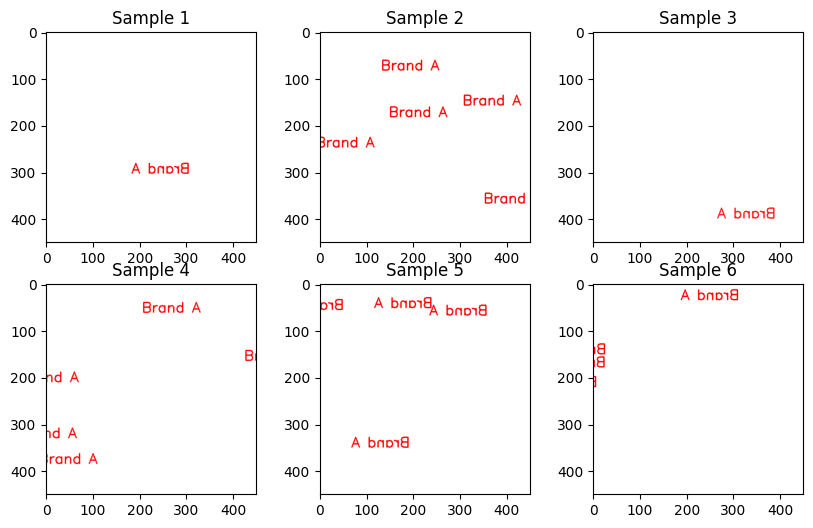

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 640x640 2 kites, 293.2ms
Speed: 10.7ms preprocess, 293.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Sample 1 - Detected 2 items



In [ ]:
# Install YOLOv8: pip install ultralytics albumentations
!pip install ultralytics albumentations
from ultralytics import YOLO
import cv2
import numpy as np
import albumentations as A
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # Load YOLOv8 small model for object detection

# Generate Synthetic Image for Counting
def generate_synthetic_product_image(item_name, count, width=640, height=480):
    image = np.ones((height, width, 3), dtype="uint8") * 255
    for i in range(count):
        x, y = np.random.randint(50, width-50), np.random.randint(50, height-50)
        cv2.putText(image, item_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
    return image

# Augmenting the synthetic image using Albumentations
augmentation_pipeline = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(blur_limit=3, p=0.1)
])

# Generate a dataset of 60 images with products
dataset = []
for i in range(60):
    synthetic_image = generate_synthetic_product_image("Brand A", count=np.random.randint(1, 6))
    augmented_image = augmentation_pipeline(image=synthetic_image)['image']
    dataset.append(augmented_image)

# Display a sample of the dataset
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {i+1}")
plt.show()

# Fine-tune YOLOv8 on your custom dataset
# model.train(data='path/to/your/custom_dataset.yaml', epochs=50, batch_size=16, imgsz=640, lr0=1e-4)

# Run YOLOv8 for detection and counting on the dataset
for i, image in enumerate(dataset[:3]):  # Test on 3 samples
    results = model.predict(source=image, show=True)
    detections = results[0].boxes.xyxy
    print(f"Sample {i+1} - Detected {len(detections)} items")


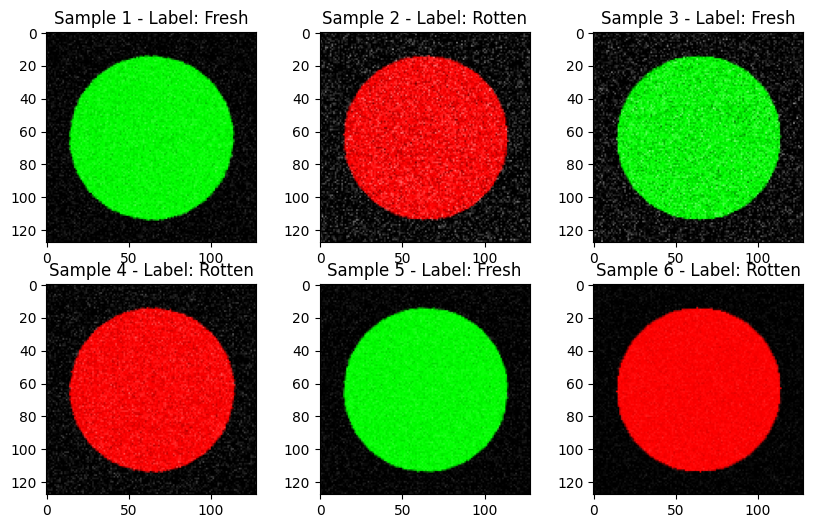

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 700ms/step - accuracy: 0.3322 - loss: 0.7246 - val_accuracy: 0.6667 - val_loss: 0.6417
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.9230 - loss: 0.6321 - val_accuracy: 1.0000 - val_loss: 0.5323
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9740 - loss: 0.5282 - val_accuracy: 1.0000 - val_loss: 0.4454
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 1.0000 - loss: 0.4724 - val_accuracy: 1.0000 - val_loss: 0.3839
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 1.0000 - loss: 0.4235 - val_accuracy: 1.0000 - val_loss: 0.3347
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 1.0000 - loss: 0.3619 - val_accuracy: 1.0000 - val_loss: 0.2878
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 1.0000 - loss: 0.3287 - val_accuracy: 1.0000 - val_loss: 0.2468
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 1.0000 - loss: 0.2921 - val_accuracy: 1

In [4]:
# Install necessary libraries: pip install tensorflow keras albumentations
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import imgaug.augmenters as iaa
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define and fine-tune EfficientNet for freshness detection
def create_freshness_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = create_freshness_model()

# Generate synthetic fruit images (fresh/rotten)
def generate_synthetic_fruit_image(freshness_label, width=128, height=128):
    image = np.ones((height, width, 3), dtype="uint8")
    color = (0, 255, 0) if freshness_label == 'Fresh' else (0, 0, 255)
    cv2.circle(image, (width//2, height//2), 50, color, -1)
    return image

# Augment images for training
augmentor = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20)),
    iaa.AdditiveGaussianNoise(scale=(10, 50))
])

# Generate a dataset of 60 synthetic images
dataset = []
labels = []
for i in range(30):
    fresh_image = generate_synthetic_fruit_image("Fresh")
    rotten_image = generate_synthetic_fruit_image("Rotten")
    dataset.append(augmentor(image=fresh_image))
    labels.append(1)  # 1 for fresh
    dataset.append(augmentor(image=rotten_image))
    labels.append(0)  # 0 for rotten

# Display a sample of the dataset
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {i+1} - Label: {'Fresh' if labels[i] == 1 else 'Rotten'}")
plt.show()

# Train and validate the model on synthetic augmented data
X_train = np.array([cv2.resize(img, (224, 224)) for img in dataset])
y_train = np.array(labels)
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2)

# Training the model with early stopping and learning rate reduction
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_freshness_model.keras', save_best_only=True, monitor='val_loss') # Changed .h5 to .keras

model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.2, callbacks=[lr_reduction, early_stopping, model_checkpoint])

# Evaluate the freshness detection model
y_pred = model.predict(X_train)
y_pred_labels = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred_labels)
precision = precision_score(y_train, y_pred_labels)
recall = recall_score(y_train, y_pred_labels)
f1 = f1_score(y_train, y_pred_labels)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
